In [ ]:
import copy
import numpy as np

import numpy as np

import galprime as gp

import photutils 
from photutils.morphology import data_properties

from matplotlib import pyplot as plt

from scipy.optimize import leastsq

from astropy import units as u

In [ ]:
models = gp.gen_sersic_models(n_models=40, width=151)

gp.plotting.show_cutouts(models, ncols=20, nrows=2)

In [176]:
class Isophote:
    
    def __init__(self, x0=None, y0=None, sma=None, eps=None, pa=None, **kwargs):
        self.x0 = x0                
        self.y0 = y0                
        self.sma = sma
        self.eps = eps
        self.pa = pa

        self.intens = None
        self.intens_err = None

        self.stop_code = 0          # 0 = No errors but fit not good enough yet, 1 = good fit, 2 = error
        self.niters = 0

        self.kwargs = kwargs

        self.n_samples = np.min([self.kwargs.get("min_samples", 20), int(2 * np.pi * self.sma)])
        self.min_samples = self.kwargs.get("min_samples", 10)
        self.fitters = [gp.AdustPmin, gp.AdustPmaj, gp.AdjustPA, gp.AdjustEllipticity]

    def get_params(self):
        return np.array([self.x0, self.y0, self.sma, self.eps, self.pa])

    def thetas(self, n_samples=None):
        n_samples = n_samples if n_samples is not None else self.n_samples
        # Return eccentric anomaly values based on a circularization of the ellipse
        phis = np.linspace(0, 2*np.pi, n_samples) 
        return gp.eccentric_anomaly(phis, self.eps)
    
    def ellipse_coords(self, thetas=None, asint=True):
        if thetas is None:
            thetas = self.thetas()
        return gp.ellipse_coords(self, thetas, asint=asint)

    def sample_image(self, data):
        """ Sample non-NaN values from the image along the isophote"""
        thetas = self.thetas()
        x, y = gp.ellipse_coords(self, thetas, asint=True)
        # Remove points outside the image
        mask = (x >= 0) & (x < data.shape[1]) & (y >= 0) & (y < data.shape[0]) #& ~np.isnan(data[x, y])
        x, y = x[mask], y[mask]
        
        nanmask = np.isnan(data[x, y])
        x, y = x[~nanmask], y[~nanmask]

        return thetas[mask], data[x, y]
    
    def intensity(self, image, thetas=None, **kwargs):
        if thetas is None:
            thetas = self.thetas()
        return np.nanmean(self.sample_image(image, **kwargs)[1])

    def gradient(self, data, E=None):
        if E is None:
            E = self.thetas()

        iso_inner, iso_outer = self.copy(), self.copy()
        iso_inner.sma *= 0.95
        iso_outer.sma *= 1.05

        return iso_outer.intensity(data, E) - iso_inner.intensity(data, E)
    
    def next_isophote(self, data, **kwargs):
        E_masked, samp = self.sample_image(data)

        err_frac = kwargs.get("err_frac", 0.04)

        if len(E_masked) < self.min_samples:
            self.stop_code = 2
            return self

        grad = self.gradient(data, E_masked)

        i0, a1, a2, b1, b2 = gp.fit_lower_harmonics(E_masked, samp)
        mod = gp.lower_harmonic_function(E_masked, [i0, a1, b1, a2, b2])
        resid = samp - mod

        lower_harmonics = np.array([a1, a2, b1, b2])
        lower_harmonics[kwargs.get("harmonic_mask", [False, False, False, False])] = 0

        largest_harmonic = np.argmax(np.abs(lower_harmonics))
        new_isophote = self.fitters[largest_harmonic](self, lower_harmonics[largest_harmonic], grad)

        good_fit = np.abs(lower_harmonics[largest_harmonic]) < err_frac * np.nanstd(resid)
        if good_fit:
            new_isophote.stop_code = 1
        new_isophote.fix_isophote()

        return new_isophote
    
    def __repr__(self) -> str:
        return f"Isophote(x0={self.x0}, y0={self.y0}, sma={self.sma}, eps={self.eps}, pa={self.pa}), stop_code={self.stop_code}"
    
    def copy(self):
        return Isophote(x0=self.x0, y0=self.y0, sma=self.sma, eps=self.eps, pa=self.pa)
    
    def fix_isophote(self, **kwargs):
        # FIX SMA
        self.sma = np.max([0, self.sma])

        # FIX EPS
        MIN_EPS, MAX_EPS = kwargs.get("MIN_EPS", 0.05), kwargs.get("MAX_EPS", 0.95)
        if self.eps < MIN_EPS:
            self.eps = MIN_EPS
        elif self.eps > MAX_EPS:
            self.eps = MAX_EPS

    def plot(self, ax=None, **kwargs):
        if ax is None:
            ax = plt.gca()
        ys, xs = self.ellipse_coords(thetas=np.linspace(0, 2*np.pi, 100), 
                                     asint=False)
        ax.plot(xs, ys, **kwargs)
        return ax


iso = Isophote(x0=75, y0=75, sma=10, eps=0.5, pa=0.1)
iso.next_isophote(models.cutouts[1])


Isophote(x0=75, y0=75, sma=10, eps=0.5, pa=0.4387112245609135), stop_code=0

In [183]:
class IsophoteFitter:
    def __init__(self, data, init_guess=None, **kwargs):
        self.data = data
        self.init_guess = init_guess
        self.kwargs = kwargs

        self.isophotes = []

        self.fitters = [gp.AdustPmin, gp.AdustPmaj, gp.AdjustPA, gp.AdjustEllipticity]

        self.fix_center = kwargs.get("fix_center", False)
        self.fix_eps = kwargs.get("fix_eps", False)
        self.fix_pa = kwargs.get("fix_pa", False)

        self.harmonic_mask = np.array([self.fix_center, self.fix_center, self.fix_pa, self.fix_eps])

        self.min_iters = kwargs.get("min_iters", 10)
        self.max_iters = kwargs.get("max_iters", 100)

        self.rmin, self.rmax = kwargs.get("rmin", 4), kwargs.get("rmax", 50)

    def fit_isophote(self, isophote, **kwargs):
        updated_isophote = isophote.next_isophote(self.data, **kwargs)
        
        for i in range(self.max_iters):
            updated_isophote = updated_isophote.next_isophote(self.data, **kwargs)            
        
        return updated_isophote


    def fit_image(self, guess=None, linear=False, step=0.1):
        if guess is None:
            guess = self.init_guess

        first_isophote = self.fit_isophote(guess, **self.kwargs)
        # Move outwards
        sma0 = first_isophote.sma
        r = sma0
        isophote = first_isophote.copy()
        while r < self.rmax:
            isophote.sma = r
            isophote = self.fit_isophote(isophote, **self.kwargs)

            self.isophotes.append(isophote)
            if linear:
                r += step
            else:
                r *= (1 + step)
            
        # Move inwards    
        r = sma0
        isophote = first_isophote.copy()
        while r > self.rmin:
            isophote.sma = r
            isophote = self.fit_isophote(isophote, **self.kwargs)

            self.isophotes.append(isophote)
            if linear:
                r -= step
            else:
                r *= (1 - step)

iso = Isophote(x0=75, y0=75, sma=10, eps=0.8, pa=np.pi / 4)


fitter = IsophoteFitter(data=models.cutouts[14], init_guess=iso, 
                        rmax=80, rmin=2)
fitter.fit_image()

print(len(fitter.isophotes))

38


(60.0, 90.0)

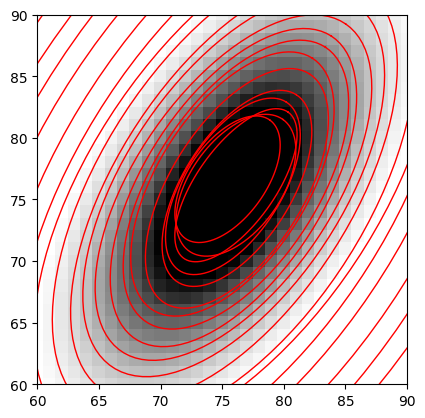

In [182]:
plt.imshow(np.log10(models.cutouts[14]), cmap="Greys", origin="lower", 
           vmin=-4, vmax=-2)

for iso in fitter.isophotes:
    iso.plot(color="red", lw=1)

plt.ylim(60, 90)
plt.xlim(60, 90)

In [175]:
phis = np.linspace(0, 2*np.pi, 100)

plt.imshow(np.log10(cutout), cmap="Greys", vmin=-5, vmax=-2)
for iso in test.isophotes:
    coords_x, coords_y = gp.ellipse_coords(iso, phis, asint=False)

    plt.plot(coords_y, coords_x, 'r', alpha=0.5)



NameError: name 'cutout' is not defined

In [ ]:
def isophote_fitting(data, init_guess=None):
    
    dp = data_properties(data)
    cols = ['xcentroid', 'ycentroid', 'semimajor_sigma', 'semiminor_sigma', 'ellipticity', 'orientation']
    tbl = dp.to_table(columns=cols)
    
    x0 = tbl['xcentroid'][0]
    y0 = tbl['ycentroid'][0]
    sma = tbl['semimajor_sigma'][0].value
    eps = tbl['ellipticity'][0]
    pa = np.deg2rad(tbl['orientation'][0].value)


    test = Isophote(x0=x0, y0=y0, sma=sma, eps=float(eps), pa=float(pa))
    try:
        fitter = IsophoteFitter(data, init_guess=test, fix_center=False)
        fitter.fit_image(linear=False, r_min=10, r_max=50)
    except UnboundLocalError:
        return
    phis = np.linspace(0, 2*np.pi, 100)

    plt.imshow(np.log10(cutout), cmap="Greys", vmin=-5, vmax=-2)
    for iso in fitter.isophotes:
        coords_x, coords_y = gp.ellipse_coords(iso, phis, asint=False)

        plt.plot(coords_y, coords_x, 'r', alpha=0.5)
    plt.show()

for i, cutout in enumerate(models.cutouts):

    isophote_fitting(cutout)